### Nivel 1
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.
Realitzaràs una visualització per a cada exercici. Comenta el que et crida l'atenció de graficar aquesta variable, justifica l'elecció del gràfic i interpreta els resultats en funció de les teves dades.

- Para conectar con MySQL, instalar: py -3.13 -m pip install mysql-connector-python
- Para manejar las claves en un archivo externo: py -3.13 -m pip install python-dotenv
- load_dotenv(): Carga las información (host,port,user, password) del archivo .env

In [208]:
from dotenv import load_dotenv
load_dotenv()


True

In [209]:
import os
import mysql.connector
from mysql.connector import Error
import pandas as pd  # Importación añadida

# 1. Establecer conexión
try:
    conexion = mysql.connector.connect(
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database="tasca4"
    )

    if conexion.is_connected():
        print("\n¡Conexión exitosa en el puerto 3307! 🚀")
        cursor = conexion.cursor()
        
        # Obtener versión
        cursor.execute("SELECT VERSION()")
        version = cursor.fetchone()
        print(f"Versión de MySQL: {version[0]}")
        
        # Paso 2: Obtener lista de tablas
        cursor.execute("SHOW TABLES")
        tablas = [tabla[0] for tabla in cursor.fetchall()]
        print("\nTablas detectadas:", ", ".join(tablas))
        
        # Paso 3: Crear diccionario de DataFrames
        dataframes = {}
        for tabla in tablas:
            print(f"Cargando {tabla}...", end=" ")
            dataframes[tabla] = pd.read_sql(f"SELECT * FROM {tabla}", conexion)
            print(f"✅ ({len(dataframes[tabla])} registros)")
        
        # Ejemplo de uso:
        # print("\nMuestra de datos de users:")
        # print(dataframes['users'].head())

except Error as e:
    print(f"\n❌ Error: {e}\n")

finally:
    # Cerrar conexión de manera segura
    if 'conexion' in locals() and conexion.is_connected():
        cursor.close()
        conexion.close()
        print("\nConexión cerrada.")


¡Conexión exitosa en el puerto 3307! 🚀
Versión de MySQL: 8.0.41

Tablas detectadas: card_status, companies, credit_cards, products, transactions, transactions_products, users
Cargando card_status... ✅ (275 registros)
Cargando companies... ✅ (100 registros)
Cargando credit_cards... ✅ (275 registros)
Cargando products... ✅ (100 registros)
Cargando transactions... ✅ (587 registros)
Cargando transactions_products... ✅ (1457 registros)
Cargando users... ✅ (275 registros)

Conexión cerrada.


C:\Users\ferna\AppData\Local\Temp\ipykernel_28132\775936074.py:34: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [210]:
card_status_df = dataframes['card_status']
companies_df = dataframes['companies']
credit_cards_df = dataframes['credit_cards']
products_df = dataframes['products']
transactions_df = dataframes['transactions']
transactions_products_df = dataframes['transactions_products']
users_df = dataframes['users']

#### Exercici 1 - Una variable numèrica
- Librería: Matplotlib
- Gráfico: Barras apiladas -> bar
- Variable Categórica: users_df['country']
- Variable Numérica: transactions_df['amount']
- Filtros: año = 2021 , declined = False

Interpretación:
- El grafico nos muestra Monto en dolares ($) de las transacciones aceptadas el año 2021, segmentadas por pais de usuario
- Esto nos permite entender cuanto contribuyen los usuarios de cada región geográfica al total del monto de las transacciones.

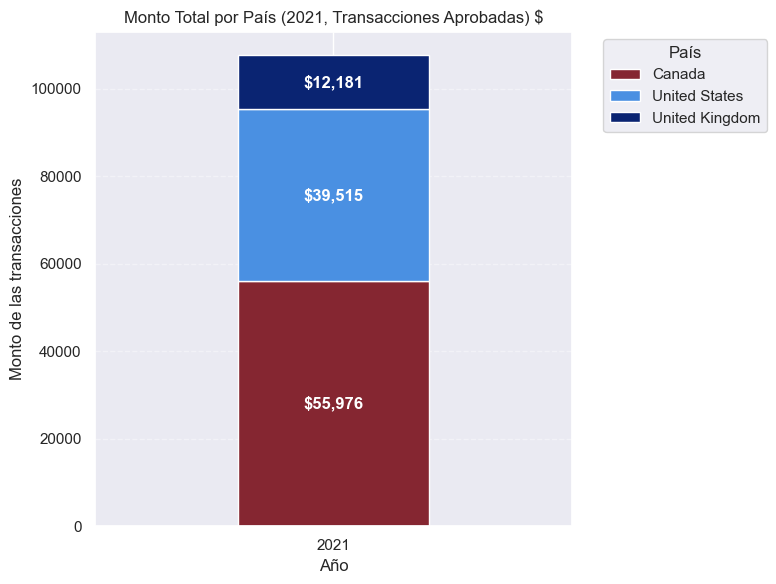

In [211]:
import matplotlib.pyplot as plt



#transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp']) 
transactions_df['year'] = transactions_df['timestamp'].dt.year 

transactions_filtradas = transactions_df[
    (transactions_df['year'] == 2021) & 
    (transactions_df['declined'] == False)
]


merged_df = transactions_filtradas.merge(
    users_df[['id', 'country']], 
    left_on='user_id', 
    right_on='id'
)

total_paises = merged_df.groupby('country')['amount'].sum().reset_index()
total_paises = total_paises.sort_values('amount', ascending=False)

colores_paises = {
    'Canada': "#852631",
    'United States': '#4A90E2',
    'United Kingdom': '#0A2472',
}


plt.figure(figsize=(8, 6))
bottom = 0


for i, row in total_paises.iterrows():
    plt.bar(
        '2021',
        row['amount'],
        bottom=bottom,
        label=row['country'],
        width=0.4,
        color=colores_paises.get(row['country'], '#CCCCCC')
    )
    
    y_position = bottom + row['amount'] / 2  # Posición vertical centrada
    plt.text(
        x=0,
        y=y_position,
        s=f"${row['amount']:,.0f}",  # Formato: $1,000
        ha='center',
        va='center',
        color='white',
        fontweight='bold'
    )

    bottom += row['amount']


plt.xlim(-0.5, 0.5)

plt.xlabel('Año')
plt.ylabel('Monto de las transacciones')
plt.title('Monto Total por País (2021, Transacciones Aprobadas) $')
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(
    axis='y',
    linestyle='--',
    alpha=0.4)
plt.show()

#### Exercici 2 - Dues variables numèriques.
- Librería: Seaborn
- Gráfico: Dispersión + Tendencia -> regplot
- Variables Numéricas: edad usarios -> users_df['birth_date'] y transactions_df['amount']
- Filtros: año = 2021 , declined = False, users_df['country'] = 'United States'

Interpretación:
- El grafico nos muestra la relación entre la edad de los usuarios que realizan transacciones, y el monto promedio de sus compras. Es un scatterplot con regresión lineal (utilizamos regplot)
- Para el contexto seleccionado, nos permite observar que en Estados Unidos, el promedio de transacción aumenta de acuerdo a la edad de los usuarios
- Si replicamos este gráfico para otras zonas geográficas, podremos observar que esta tendencia no se replica en Canada ni el Reino Unido

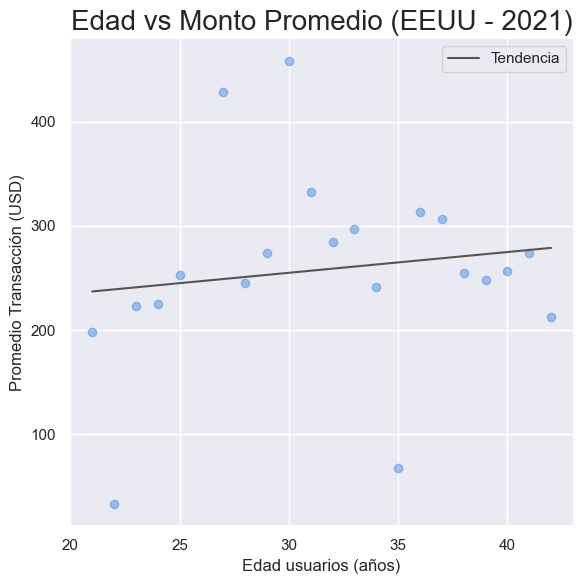

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt

#Alias de dataframes, filtros transactions y conversión de timestamp - ejercicio 1

users_df['birth_date'] = pd.to_datetime(users_df['birth_date'])

users_filtrados = users_df[
    (users_df['country'] == 'United States')][['id', 'birth_date']]

merged_df = transactions_filtradas.merge(
    users_filtrados,
    left_on='user_id', 
    right_on='id'
)

merged_df['age'] = merged_df['timestamp'].dt.year - merged_df['birth_date'].dt.year

user_stats = merged_df.groupby(['age'])['amount'].mean().reset_index()

plt.figure(figsize=(6, 6))
grafico = sns.regplot(
    data=user_stats,
    x='age',
    y='amount',
    ci= None,
    scatter=True,
    line_kws={'linewidth': 1.5, 'label': 'Tendencia', 'color' : "#575453"},
    scatter_kws={'label': 'Datos', 'alpha': 0.5, 'color' : '#4A90E2'}
)

grafico.axes.set_title("Edad vs Monto Promedio (EEUU - 2021)",fontsize=20)
plt.tight_layout()

plt.xlabel("Edad usuarios (años)", fontsize=12)
plt.ylabel("Promedio Transacción (USD)", fontsize=12)
plt.legend()
plt.show()


#### Exercici 3- Una variable categòrica.
- Librería: Plotly
- Gráfico: Sunburst
- Variables Categóricas: companies_df['company_name'] y companies_df['country']
- Variable Numérica: transactions_df['amount']
- Filtros: año = 2021 , declined = False

Interpretación:
- El grafico nos muestra que compañias aportan más al monto de las transacciones, y de que paises son estas compañias

In [225]:
import plotly.express as px

merged_df = transactions_filtradas.merge(
    companies_df[['company_name', 'country', 'company_id']], 
    left_on='business_id', 
    right_on='company_id'
)

fig = px.sunburst(merged_df, path=['country','company_name'], values='amount',title= 'Monto transacciones por pais de compañia y compañia')
fig.show()

#### Exercici 4
Una variable categòrica i una numèrica.
- Librería: Seaborn
- Gráfico: Boxplot
- Variable Categórica: users_df['country']
- Variable Numérica: transactions_df['amount']
- Filtros: año = 2021 , declined = False

Interpretación:
- El grafico nos muestra la distribucion en cuartiles de los montos de compras, según el area geográfica de los usuarios.
Por ejemplo, nos permite observar que en el Reino Unido, las compras tienden a ser de montos menores.

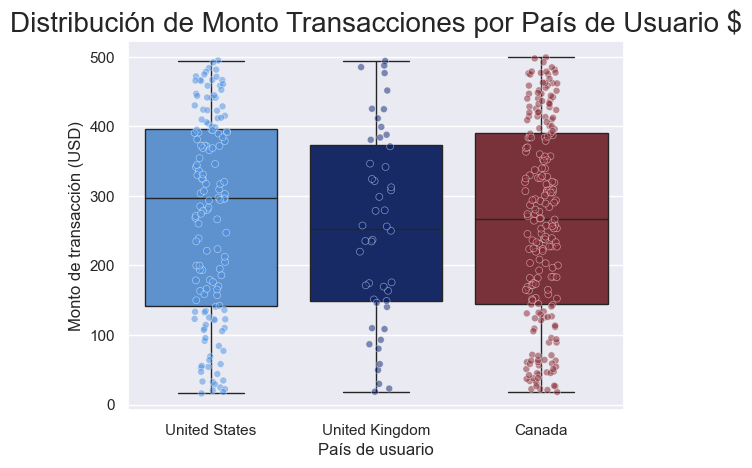

In [214]:
#Sobrescribo dataframe para incluir paises de usuarios
merged_df = transactions_filtradas.merge(
    users_df[['id', 'country']], 
    left_on='user_id', 
    right_on='id'
)

grafico = sns.boxplot(merged_df, x='country', y='amount', hue='country', palette=colores_paises)

sns.stripplot(
    data=merged_df,
    x='country',
    y='amount',
    hue='country',
    palette=colores_paises,
    legend=False,
    alpha=0.5,
    jitter=True,
    linewidth=0.5,
    edgecolor='white',
    ax=grafico #Para graficar las modificaciones en el mismo lienzo
)


grafico.axes.set_title("Distribución de Monto Transacciones por País de Usuario $",fontsize=20)
plt.xlabel("País de usuario", fontsize=12)
plt.ylabel("Monto de transacción (USD)", fontsize=12)
plt.show()


#### Exercici 5
Dues variables categòriques.
- Librería: Matplotlib - Seaborn
- Gráfico: Barplot
- Variables Categóricas: users_df['country'] y transactions_df['declined']
- Filtros: año = 2021

Interpretación:
- El gráfico nos muestra la cantidad de transacciones por pais de usuario y estado declinado/aceptado. Podemos observar que para el año 2021, la totalidad de las transacciones declinadas, se originaron al momento de compra de usuarios ubicados en Canadá.


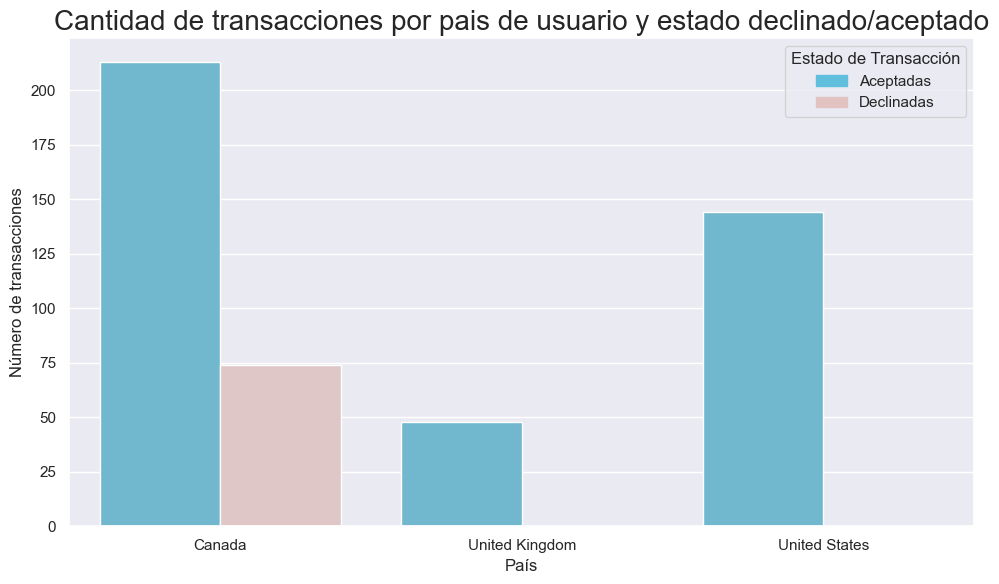

In [215]:
import matplotlib.patches as mpatches

paleta_declined = {
    0: "#61BFDE",
    1: "#E2C3C2"
}

handles = [
    mpatches.Patch(color=paleta_declined[0], label='Aceptadas'),
    mpatches.Patch(color=paleta_declined[1], label='Declinadas')
]

#Sobrescribo transacciones filtradas para incluir transacciones declinadas
transactions_filtradas = transactions_df[
    (transactions_df['year'] == 2021)
]

merged_df = transactions_filtradas.merge(
    users_df[['id', 'country']], 
    left_on='user_id', 
    right_on='id'
)

counts = merged_df.groupby(['country', 'declined']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
grafico = sns.barplot(
    x='country',
    y='count',
    hue='declined',
    data=counts,
    palette= paleta_declined
)

grafico.axes.set_title("Cantidad de transacciones por pais de usuario y estado declinado/aceptado",fontsize=20)
plt.xlabel("País")
plt.ylabel("Número de transacciones")
plt.legend( handles=handles,
           title='Estado de Transacción',
           loc='upper right')
plt.tight_layout()
plt.show()


#### Exercici 6- Tres variables.
- Librería: Seaborn, Matplotlib
- Gráfico: lmplot
- Variable Categórica: users_df['country']
- Variables Numéricas: edad usuarios -> users_df['birth_date'] y transactions_df['amount']
- Filtros: año = 2021 , declined = False

Interpretación:
- El grafico nos muestra la relación entre la edad de los usuarios que realizan transacciones, y el monto promedio de sus compras.
Se muestra un gráfico de dispersión, y una regresión lineal para cada pais de usuario.
En esta extensión, del gráfico del ejercicio 2, podemos observar que usuarios de mayor edad hacen en promedio transacciones más grandes en Estados Unidos, mientras lo contrario de da en Canada y el Reino Unido.

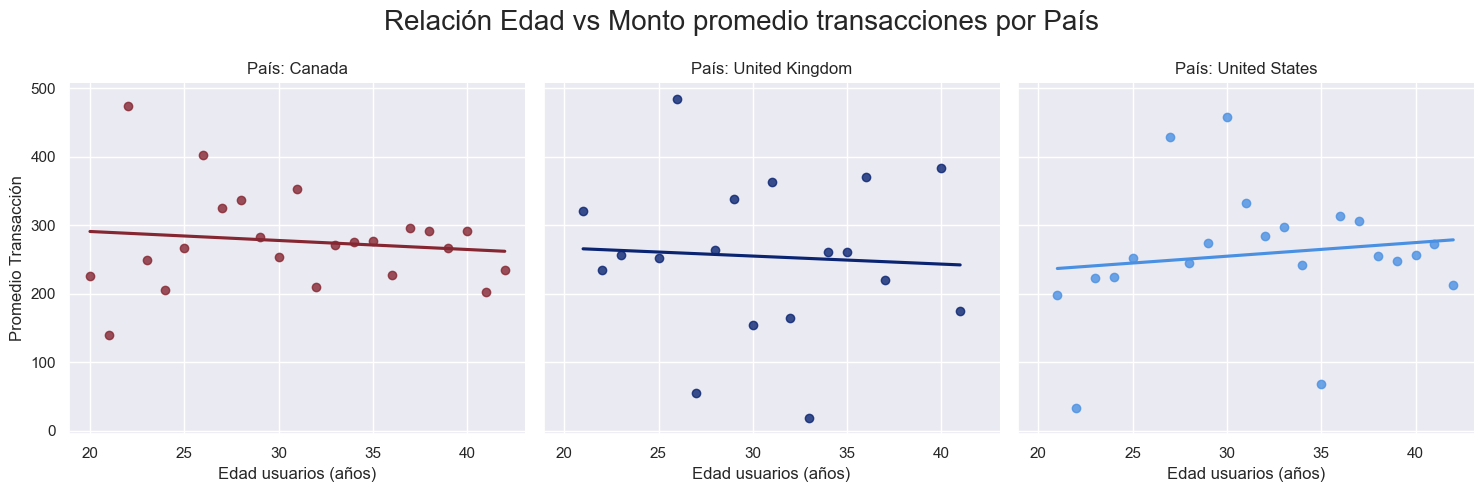

In [216]:
#Sobrescribo transacciones filtradas para excluir transacciones declinadas
transactions_filtradas = transactions_df[
    (transactions_df['year'] == 2021) & 
    (transactions_df['declined'] == False)
]

#users_df['birth_date'] = pd.to_datetime(users_df['birth_date'])
users_filtrados = users_df[['id', 'birth_date', 'country']].rename(
    columns={
        'id': 'user_id'
    }
)

merged_df = transactions_filtradas.merge(
    users_filtrados,
    left_on='user_id', 
    right_on='user_id'
)

merged_df['age'] = merged_df['timestamp'].dt.year - merged_df['birth_date'].dt.year

user_stats = merged_df.groupby(['age','country'])['amount'].mean().reset_index()
user_stats

grafico = sns.lmplot(user_stats, x='age', y='amount',col='country',hue='country', palette=colores_paises, ci=None)

grafico.set_axis_labels(
    x_var="Edad usuarios (años)",
    y_var="Promedio Transacción"
)

grafico.set_titles("País: {col_name}")

plt.subplots_adjust(top=0.85)
grafico.figure.suptitle("Relación Edad vs Monto promedio transacciones por País", size = 20)
plt.tight_layout()
plt.show()

#### Exercici 7- Graficar un Pairplot.
- Librería: Seaborn
- Gráfico: Pairplot
- Variable Categórica: users_df['country']
- Variables Numéricas: edad usuarios -> users_df['birth_date'] y transactions_df['amount']
- Filtros: año = 2021 , declined = False

Interpretación:
- El Pair plot nos entrega 3 gráficos:
- El gráfico de la esquina superior izquierda, nos muestra la densidad de las edades de los usuarios, para cada país de usuario.
- El gráfico de la esquina inferior derecha, nos muestra la densidad de los montos de transacciones de los usuarios,por país.
- El gráfico de la esquina inferior izquierda, nos muestra la relación entre la edad de los usuarios, y el total de sus montos de transacciones. Tenemos una dispersión, junto con una regresión, para cada pais de usuario.

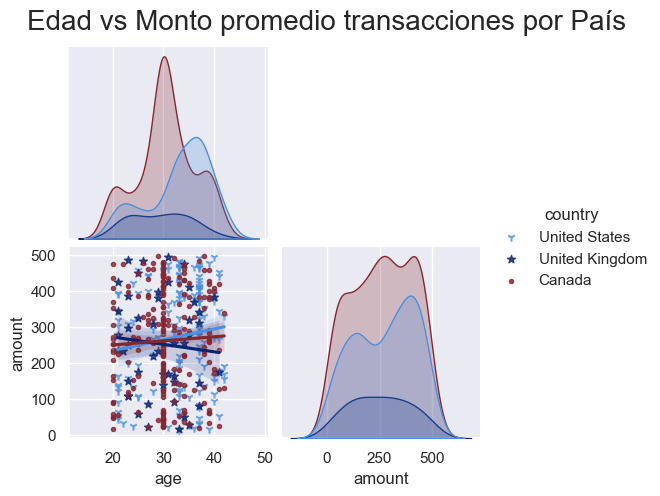

In [217]:
grafico = sns.pairplot(merged_df,vars=["age", "amount"], kind='reg', diag_kind='kde', corner=True, hue='country', palette=colores_paises, markers=['1','*','.'])
grafico.figure.suptitle("Edad vs Monto promedio transacciones por País", size = 20)
grafico.tight_layout()
plt.show()

###  Nivell 2

#### Exercici 1
Correlació de totes les variables numèriques.

Variables Numericas:
- card_status: None
- companies: None
- credit_cards: (user_id) -> None

- users: birth_date -> Extraer edad de birth_date en columna nueva e incluir.
- transactions: timestamp, amount, (declined, user_id, lat, longitude),year -> Incluir dataframe. Ignorar (declined, user_id, lat, longitude),
Extraer mes de timestamp en columna nueva e incluir.
- transactions_products: (id_products) -> Incluir como puente
- products: (id) price, weight -> Incluir dataframe.Ignorar 'id'


In [218]:
#Revisamos que tablas contienen valores numericos (relevantes). Los id los consideramos categóricos
print(card_status_df.dtypes)
print(companies_df.dtypes)
print(credit_cards_df.dtypes)
print(products_df.dtypes)
print(transactions_df.dtypes)
print(transactions_products_df.dtypes)
print(users_df.dtypes)

card_id    object
status     object
dtype: object
company_id      object
company_name    object
phone           object
email           object
country         object
website         object
dtype: object
id               object
user_id           int64
iban             object
pan              object
pin              object
cvv              object
track1           object
track2           object
expiring_date    object
dtype: object
id                int64
product_name     object
price           float64
colour           object
weight          float64
warehouse_id     object
dtype: object
id                     object
card_id                object
business_id            object
timestamp      datetime64[ns]
amount                float64
declined                int64
product_ids            object
user_id                 int64
lat                   float64
longitude             float64
year                    int32
dtype: object
id_transaction    object
id_product         int64
dtype: object
id

Columna: age
stat = 0.760, p = 0.000
Probablemente NO sigue distribución normal

Columna: amount
stat = 0.760, p = 0.000
Probablemente NO sigue distribución normal

Columna: price
stat = 0.760, p = 0.000
Probablemente NO sigue distribución normal

Columna: weight
stat = 0.760, p = 0.000
Probablemente NO sigue distribución normal



c:\Users\ferna\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5828.



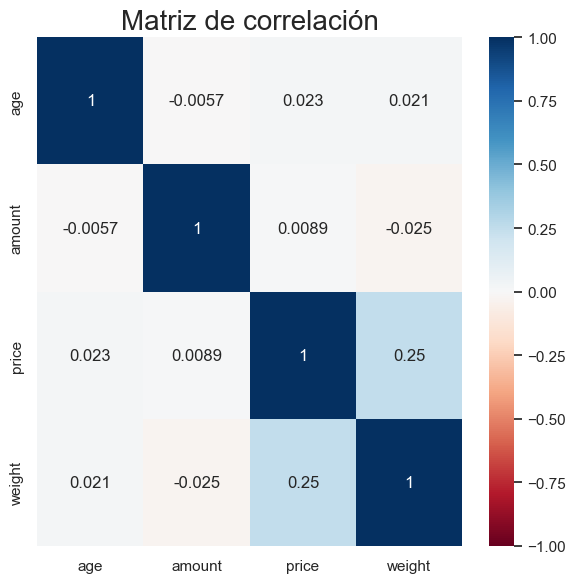

In [219]:
from scipy.stats import shapiro #Para hacer tests de normalidad

#Filtrar antes del merge
users_filtrados = users_df[['id', 'birth_date', 'country']].rename(
    columns={
        'id': 'user_id'
    }
)
transactions_filtrados = transactions_df[['id','user_id','year','amount', 'declined']].rename(
    columns={
        'id' : 'id_transaction',
        'year': 'transaction_year'
    }
)
products_filtrados = products_df[['id','price', 'weight']].rename(
    columns={
        'id' : 'id_product'
    }
)

# Merge de dataframes con variables numéricas
merged_df = users_filtrados.merge(
    transactions_filtrados, 
    left_on='user_id', 
    right_on='user_id', 
    how='inner'
).merge(
    transactions_products_df, 
    left_on='id_transaction', 
    right_on='id_transaction', 
    how='inner'
).merge(
    products_filtrados, 
    left_on='id_product', 
    right_on='id_product', 
    how='inner'
)

merged_df['age'] = merged_df['transaction_year']- merged_df['birth_date'].dt.year

merged_data_corr = merged_df[['age', 'amount', 'price', 'weight']]

for col in ['age', 'amount', 'price', 'weight']:
    stat, p = shapiro(merged_data_corr)
    print(f'Columna: {col}')
    print('stat = %.3f, p = %.3f' % (stat, p))
	
    if p > 0.05:
        print('Probable distribución normal\n')
    else:
        print('Probablemente NO sigue distribución normal\n')


#Como los datos no siguen una distribución normal, no podemos usar la correlacion de Pearson
# matriz_correlacion = merged_data_corr.corr()
# Debemos utilizar la correlacion de Spearman

matriz_correlacion = merged_data_corr.corr(method='spearman')

matriz_correlacion
plt.figure(figsize=(6, 6))
grafico = sns.heatmap(matriz_correlacion, annot=True, cmap='RdBu', vmin=-1, vmax=1)
grafico.axes.set_title("Matriz de correlación",fontsize=20)
plt.tight_layout()
plt.show()


#### Exercici 2
Implementa un jointplot.
- Librería: Seaborn
- Gráfico: Jointplot
- Variables Categóricas: users_df['country']
- Variable Numérica: edad usarios -> users_df['birth_date'] y transactions_df['amount']
- Filtros: año = 2021 , declined = False

Interpretación:
- En la parte superior del gráfico, podemos ver la densidad de edades de los usuarios, para cada pais. Notamos una alta concentración de usuarios de arrededor de 30 años en Canadá, mientras que en Estados Unidos los usuarios de concentran más entre los 35 y 40 años de edad.
- Al costado derecho podemos ver la densidad de montos de compra. Podemos ver para cada pais cuanto volumen de transacciones tienen, pero además podemos distinguir segmentos de usuarios según su nivel de gasto. Mientras que en Estados Unidos hay un grupo de usuarios con altos montos de compra, en el Reino Unido la distribución de montos es relativamente más plana.
- Al centro del gráfico podemos observar la dispersión de montos de compras, según la edad de los usuarios, diferenciados por pais. Al no agrupar por edad, podemos observar de mejor manera la concentración de usuarios por pais, en determinados rangos de edad.

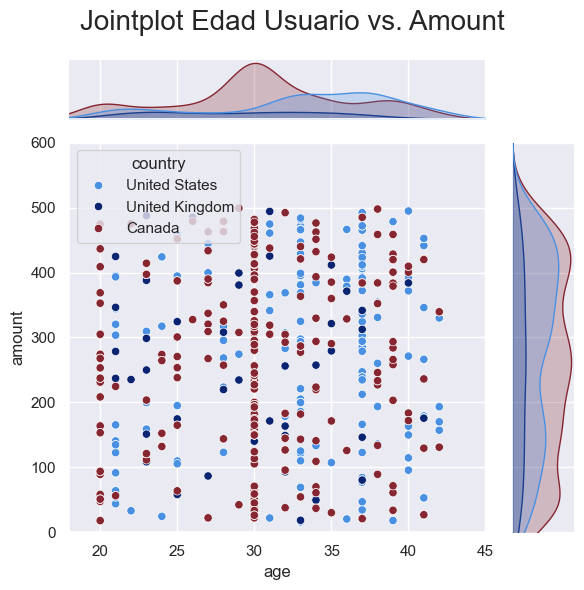

In [220]:
filtered_df = merged_df[(merged_df['transaction_year'] == 2021) & (merged_df['declined'] == False)]

grafico = sns.jointplot(data=filtered_df, x="age", y="amount", hue='country', space=0, xlim=[18,45], ylim=[0,600], palette=colores_paises)
grafico.figure.suptitle("Jointplot Edad Usuario vs. Amount", size = 20)
plt.tight_layout()
plt.show()

### Nivell 3

#### Exercici 1 - Implementa un violinplot combinat amb un altre tipus de gràfic.
- Librería: Seaborn
- Gráfico: Violinplot
- Variable Categórica: transactions_df['year'], transactions_df['declined']
- Variables Numéricas: transactions_df['amount']

Interpretación:
- El violinplot nos muestra la densidad de distribución de montos de transacciones. Cada mitad del violín, es la densidad según la variable categórica 'declined'. Tenemos un violín segñun si los datos son del año 2021 o 2022.
- Podemos observar una concentración de transacciones de montos mñas pequeños en lo que va del año 2022. Tembién podemos observar que las transacciones aceptadas por lo general, tienen montos levemente más grandes que las declinadas.

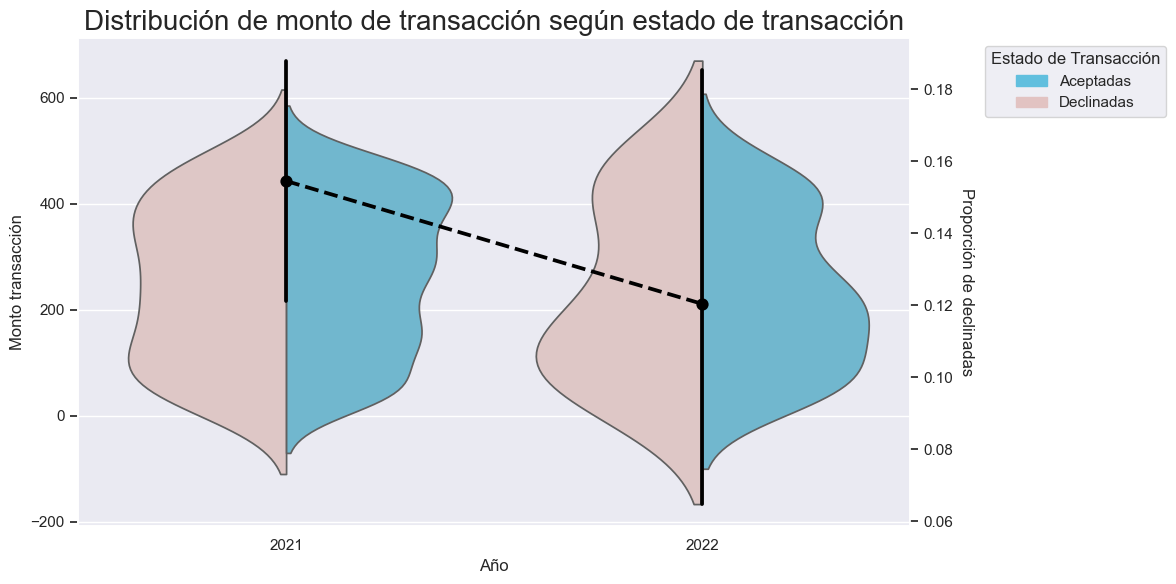

In [221]:
#import matplotlib.patches as mpatches

paleta_declined = {
    0: "#61BFDE",
    1: "#E2C3C2"
}

fig, ax1 = plt.subplots(figsize=(12, 6))

grafico_violin = sns.violinplot(
    data=transactions_filtrados,
    x='transaction_year',
    y='amount',
    hue="declined",
    split=True,
    palette=paleta_declined,
    hue_order=[1,0],
    legend=False,
    inner=None,
    ax=ax1)

grafico_violin.set(
    xlabel='Año', 
    ylabel='Monto transacción'
)

grafico_violin.axes.set_title("Distribución de monto de transacción según estado de transacción",fontsize=20)

ax2 = ax1.twinx()

sns.pointplot(
    x='transaction_year',
    y='declined',
    data=transactions_filtrados,
    estimator='mean', 
    color='black',
    linestyles='--',
    ax=ax2,
    legend=False
)

ax2.set_ylabel('Proporción de declinadas', rotation=270, labelpad=15)
ax2.grid(False)

handles = [
    mpatches.Patch(color=paleta_declined[0], label='Aceptadas'),
    mpatches.Patch(color=paleta_declined[1], label='Declinadas')
]

plt.legend( handles=handles,
           title='Estado de Transacción',
           bbox_to_anchor=(1.08, 1),
           loc='upper left')
plt.tight_layout()
plt.show()


#### Exercici 2 - Genera un FacetGrid per a visualitzar múltiples aspectes de les dades simultàniament.
- Librería: Seaborn
- Gráfico: FacetGrid
- Variable Categórica: transactions_df['month'], users_df['country'], companies_df['country']
- Variables Numéricas: transactions_df['amount']
- Filtros: año = 2021 , declined = False

Interpretación:
- El FacetGrid nos entrega un gráfico, para cada combinación de país de usuario y de compañia, y nos muestra la evolución del monto de transacciones a lo largo del año seleccionado (2021)

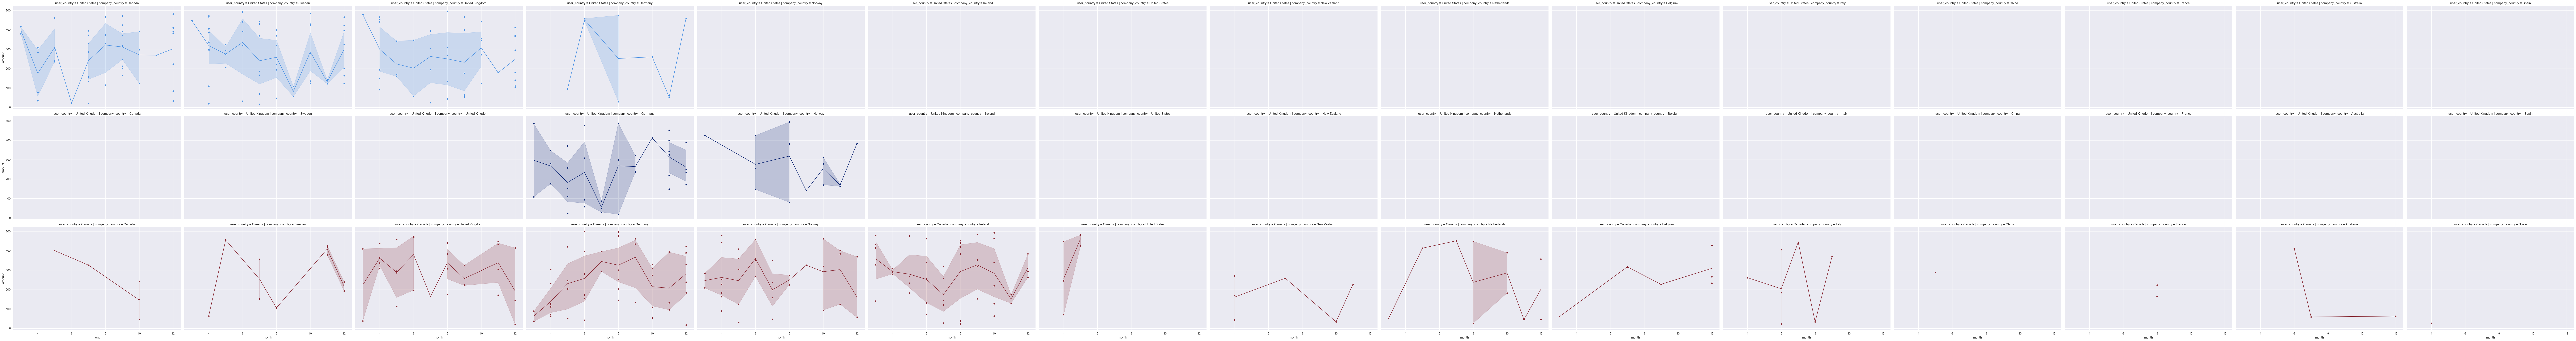

In [222]:
users_filtrados = users_df[['id', 'birth_date', 'country']].rename(
    columns={
        'id': 'user_id',
        'country': 'user_country',

    }
)

transactions_df['year'] = transactions_df['timestamp'].dt.year
transactions_df['month'] = transactions_df['timestamp'].dt.month 


transactions_filtrados = transactions_df[(transactions_df['year'] == 2021)& (transactions_df['declined'] == False)][['id','user_id','business_id','year','month','amount', 'declined']].rename(
    columns={
        'id' : 'id_transaction',
        'year': 'transaction_year'
    }
)
companies_filtrados = companies_df[['company_id','country','company_name']].rename(
    columns={
        'company_id' : 'business_id',
        'country': 'company_country',

    }
)

merged_df = users_filtrados.merge(
    transactions_filtrados,
    on='user_id',
    how= 'inner'
). merge(
    companies_filtrados,
    on='business_id',
        how= 'inner'
)

sns.set_theme(style="darkgrid")
merged_df['age'] = merged_df['transaction_year']- merged_df['birth_date'].dt.year
grafico = sns.FacetGrid(
    merged_df, 
    col='company_country',
    row='user_country', 
    hue='user_country', 
    palette=colores_paises,
    height=6,
    aspect=1.5)


grafico.map_dataframe(sns.lineplot, x="month", y="amount", legend='full')
grafico.map_dataframe(sns.scatterplot, x="month", y="amount", legend='full')
plt.tight_layout()
plt.show()
